# Experiments with the WaterberryFarm classes

In [ ]:
# allow imports from the main source directory
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.path import Path
from matplotlib import animation
from functools import partial
import numpy as np
import math
import bz2
import unittest
import timeit
import pathlib 
import pickle
import copy
import logging
# logging.basicConfig(level=logging.WARNING)
logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)

from environment import Environment, EpidemicSpreadEnvironment, DissipationModelEnvironment, PrecalculatedEnvironment
from InformationModel import StoredObservationIM, GaussianProcessScalarFieldIM, DiskEstimateScalarFieldIM, im_score, im_score_weighted

from WaterberryFarm import WBF_IM_DiskEstimator, create_wbfe, WBF_Score_WeightedAsymmetric


## Verifying that the mask is working correctly.

INFO:root:loading the geometry and environment from saved data


Loading pointer config file: C:\Users\lboloni\.config\WaterBerryFarms\mainsettings.yaml
Loading machine-specific config file: G:\My Drive\LotziStudy\Code\PackageTracking\WaterBerryFarms\settings\WBF-config-LotziYoga.yaml


INFO:root:loading done
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661 0.99924746 0.99943559 0.99957669 0.99968252 0.99976189
 0.99982142 0.99986606 0.99989955 0.99992466 0.9999435  0.99995762
 0.99996822 0.99997616 0.99998212 0.99998659 0.99998994 0.99999246
 0.99999434 0.99999576 0.99999682 0.99999761 0.99999821 0.99999866
 0.99999899 0.99999924 0.99999943 0.99999958 0.99999968 0.99999976
 0.99999982 0.99999987 0.9999999  0.99999992 0.99999994 0.99999996
 0.99999997 0.99999998 0.99999998 0.99999999 0.99999999 0.99999999
 0.99999999 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1

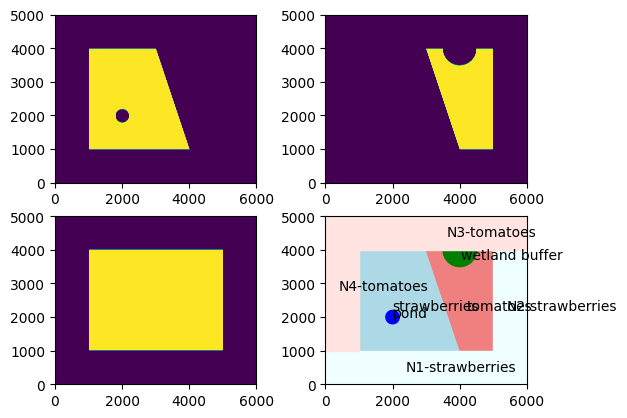

In [2]:
wbf, wbfe, savedir = create_wbfe(False, None, typename = "Waterberry")
#wbf, wbfe = load_precalculated_wbfe()
#wbfe.visualize()
#logging.info("Visualize done, proceed to animate")
# This is working at approximately 2 sec per frame for the environment progress. Not very fast, but it should be roughly ok. 
# anim = wbfe.animate_environment()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
ax1.imshow(wbfe.my_strawberry_mask.T, origin="lower")
ax2.imshow(wbfe.my_tomato_mask.T, origin="lower")
ax3.imshow(wbfe.my_soil_mask.T, origin="lower")
wbfe.geometry.visualize(ax4)

plt.show()

## Put everything together, measure the score for a set of observations


INFO:root:loading the geometry and environment from saved data
INFO:root:loading done
INFO:root:Infection matrix: [0.         0.25       0.4375     0.578125   0.68359375 0.76269531
 0.82202148 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486
 0.96832365 0.97624274 0.98218205 0.98663654 0.9899774  0.99248305
 0.99436229 0.99577172 0.99682879 0.99762159 0.99821619 0.99866214
 0.99899661 0.99924746 0.99943559 0.99957669 0.99968252 0.99976189
 0.99982142 0.99986606 0.99989955 0.99992466 0.9999435  0.99995762
 0.99996822 0.99997616 0.99998212 0.99998659 0.99998994 0.99999246
 0.99999434 0.99999576 0.99999682 0.99999761 0.99999821 0.99999866
 0.99999899 0.99999924 0.99999943 0.99999958 0.99999968 0.99999976
 0.99999982 0.99999987 0.9999999  0.99999992 0.99999994 0.99999996
 0.99999997 0.99999998 0.99999998 0.99999999 0.99999999 0.99999999
 0.99999999 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.      

AttributeError: 'WaterberryFarmEnvironment' object has no attribute 'visualize'

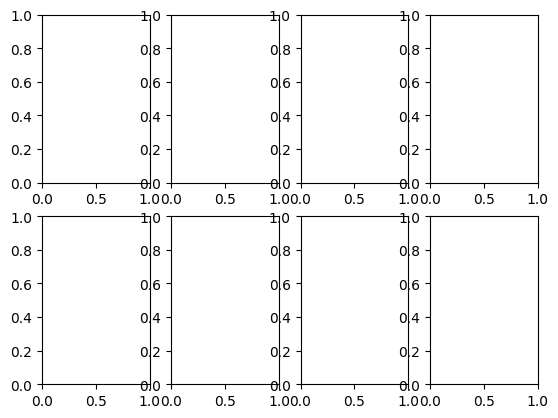

In [3]:
wbf, wbfe, savedir = create_wbfe(False, None, typename = "Waterberry")
# observation locations
# for waterberry
# locations = [[10, 10], [500, 500], [1500, 1500]]
# for miniberry
locations = [[10, 10], [30, 30], [50, 50]]
observations = []
wbfim = WBF_IM_DiskEstimator(wbf.width, wbf.height)
for location in locations:
    x = location[0]
    y = location[1]
    value_tylcv = wbfe.tylcv.value[x, y]
    value_ccr = wbfe.ccr.value[x, y]
    value_soil = wbfe.soil.value[x, y]
    observation = {}
    observation["TYLCV"] = {wbfim.X : x, wbfim.Y : y, wbfim.VALUE : value_tylcv}
    observation["CCR"] = {wbfim.X : x, wbfim.Y : y, wbfim.VALUE : value_ccr}
    observation["Soil"] = {wbfim.X : x, wbfim.Y : y, wbfim.VALUE : value_soil}
    observations.append(observation)
for observation in observations:
    wbfim.add_observation(observation)
logging.info("waterberry information model: proceed(1)")
wbfim.proceed(1)
logging.info("done waterberry information model: proceed(1)")
logging.info("starting to calculate score for waterberry information model")
scorecode = WBF_Score_WeightedAsymmetric()
score = scorecode.score(wbfe, wbfim)
logging.info(f"Waterberry information model score: {score}")
# now visualize the environment and the information model
fig, axes = plt.subplots(2,4)        
wbfe.visualize(fig, axes[0,0], axes[0,1], axes[0,2], axes[0,3])

image_im_tylcv = axes[1,1].imshow(wbfim.im_tylcv.value.T, vmin=0, vmax=1, origin="lower")
axes[1,1].set_title("TYLCV im")
image_im_ccr = axes[1,2].imshow(wbfim.im_ccr.value.T, vmin=0, vmax=1, origin="lower")
axes[1,2].set_title("CCR im")
image_im_ccr = axes[1,3].imshow(wbfim.im_soil.value.T, vmin=0, vmax=1, origin="lower")
axes[1,3].set_title("SOIL im")
plt.show()